<a href="https://colab.research.google.com/github/Thomines/Coral_MobileNetV2_Project_GreenAI_DIA6/blob/main/Green_AI_coral_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install roboflow


In [2]:
from roboflow import Roboflow #Importing data from roboflow
rf = Roboflow(api_key="D99TnI5lpiZAShCWHZag") #API Key of the dataset
project = rf.workspace("aobaob").project("coral-1q4rj")
version = project.version(4)
dataset = version.download("folder")

loading Roboflow workspace...
loading Roboflow project...


Dataset path: /content/coral-4
Image filepath = /content/coral-4/train/bleached_corals/4959974094_b29988f09b_o_jpg.rf.c38a265581eb669f797c1855daead436.jpg


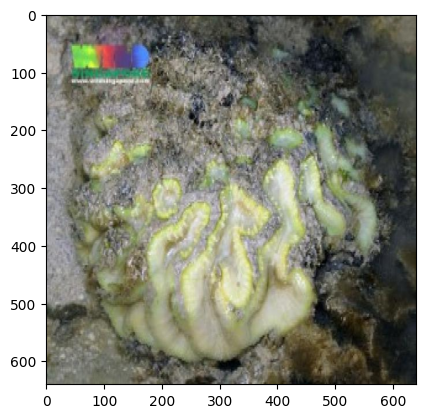

In [3]:
import os #OS for moving into files and directories
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

dataset_path = dataset.location #Roboflow dataset.location
print("Dataset path:", dataset_path)
#shows the first image in the imported dataset so we can see if we manage to import an image
first_image = None
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(('.jpg', '.jpeg','.png')):
            first_image= os.path.join(root, file) #combines both parts of the filepath
            break
    if first_image:
        break

print("Image filepath =", first_image) #to know what the image path looks like for later

img = mpimg.imread(first_image)
plt.imshow(img)
plt.show()


In [4]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
import os
Data_loc = dataset.location
IMG_SIZE = (224, 224) #resizing images in a fixed format (less training time + formalisation) & this is how mobilenet is supported
BATCH    = 32
SEED     = 42

train_ds = image_dataset_from_directory( #Creates the training set for tensorflow
    os.path.join(Data_loc, "train"),
    image_size=IMG_SIZE, batch_size=BATCH, shuffle=True, seed=SEED
)
val_ds = image_dataset_from_directory( #Creates the validation set for tensorflow
    os.path.join(Data_loc, "valid"),
    image_size=IMG_SIZE, batch_size=BATCH, shuffle=False
)
test_ds = image_dataset_from_directory( #creates the test set for tensorflow
    os.path.join(Data_loc, "test"),
    image_size=IMG_SIZE, batch_size=BATCH, shuffle=False
)
class_names =train_ds.class_names
print("class_names :", class_names) #to see what is inside the files for later

Found 632 files belonging to 2 classes.
Found 182 files belonging to 2 classes.
Found 91 files belonging to 2 classes.
class_names : ['bleached_corals', 'healthy_corals']


Batch images: (32, 224, 224, 3)
Coreesponding labels: [0 1 1 0 1 1 0 0 0 0]


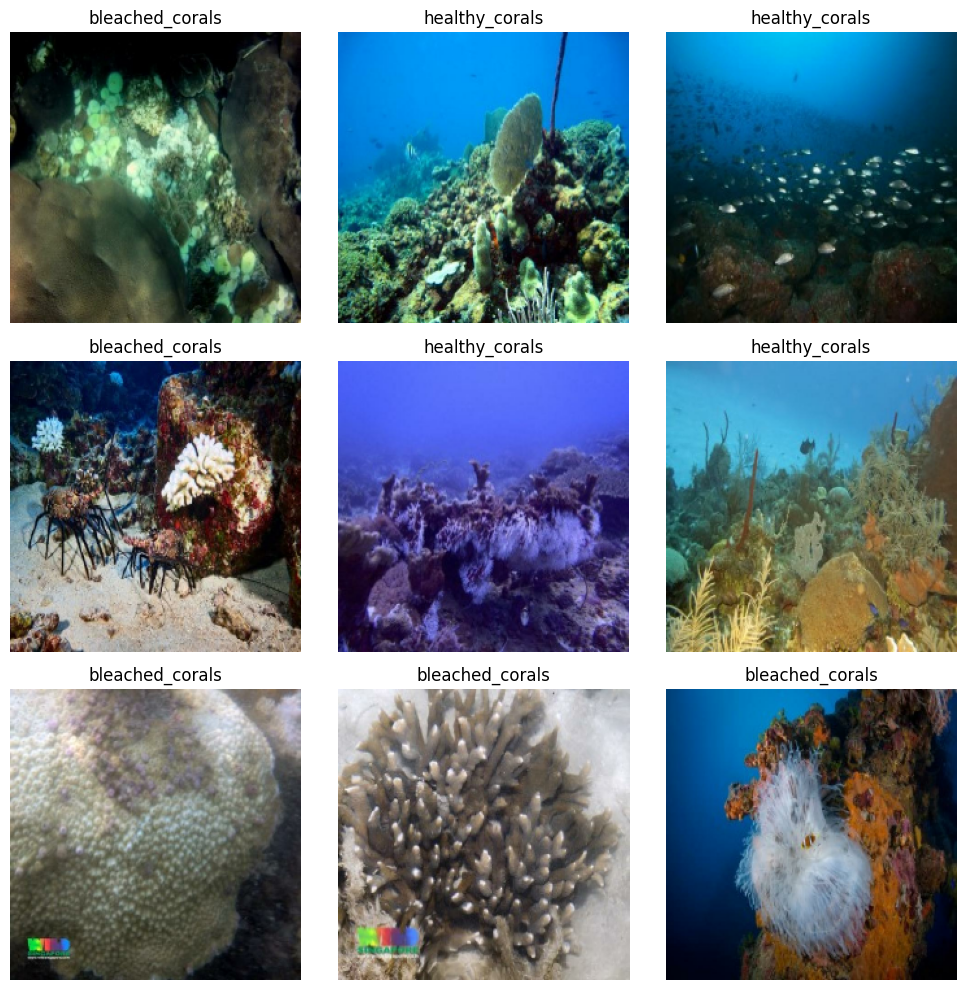

In [5]:
import matplotlib.pyplot as plt
#Showing what a batch looks like
images, labels = next(iter(train_ds))

print("Batch images:", images.shape)
print("Coreesponding labels:", labels.numpy()[:10]) #We can see below that healthy and bleached corals are correctly labeled comapred to the 0-1
n = min(9, images.shape[0]) #if not img.shape and our batch is smaller than 9, we get an error
plt.figure(figsize=(10,10))
for i in range(n):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8")) #using uint8 lets us have correct format for the images from tf to plt
    label_idx = int(labels[i].numpy()) #putting lables
    plt.title(class_names[label_idx])
    plt.axis("off")
plt.tight_layout()
plt.show()


In [6]:
AUTOTUNE = tf.data.AUTOTUNE #Here we use cache() and AUTOTUNE to make the training faster
train_ds = train_ds.cache().shuffle(1000,seed=42).prefetch(AUTOTUNE) #we have to add seed so that we get the same result each time, else, we don't have the same accuracy every time
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)

In [7]:
import tensorflow as tf
#Data augmentation to create more training data (which reduces overfitting and improves the model overall since our collection of images isn't that big)
data_augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.1),
], name="augment")

base = tf.keras.applications.MobileNetV2( #MobileNetV2 model because it is léger and fast
    input_shape=(224,224,3), include_top=False, weights="imagenet" #weigths included in Mobilenetv2
)
base.trainable = False #Freezes weights so fastert because less GPU usage since we don't have to recompute everyweight all the time

inputs= tf.keras.Input(shape=(224,224,3))
x= tf.keras.applications.mobilenet_v2.preprocess_input(inputs) #preprocessing
x= data_augment(x) #dataaugmentation
x= base(x, training= False) #setting the base as the frozen
x= tf.keras.layers.GlobalAveragePooling2D()(x) #Explained in the roboflow tutorial to make a model
x= tf.keras.layers.Dropout(0.2)(x) #For less overfitting, we can test without as well
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x) #Last layer of the model that predicts our binary result, 1 because we have binary ressult, activation = sigmoid is better for binary result

model = tf.keras.Model(inputs, outputs, name="Coral_model_MobileNetV2")#Model creation
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy", #this is the only one that is binary
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc"), tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall")],
)
model.summary()


Model: "Coral_model_MobileNetV2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augment (Sequential)            │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint #Early stopping to gain time as it stops training when values stop improving
import os

checkpoint_patha = "/content/best_coral_cls.h5"
lescallbacks = [
    EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True), #here it stops when val_accuracy stops improving
    ModelCheckpoint(checkpoint_patha, monitor="val_accuracy", save_best_only=True) #when val_accuracy is the highest, way too much overfitting without that
]

history = model.fit(
    train_ds, validation_data=val_ds,
    epochs=10, callbacks=lescallbacks,
    class_weight=None
)


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7902 - auc: 0.8803 - loss: 0.4374 - precision: 0.7706 - recall: 0.8043

20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.7903 - auc: 0.8805 - loss: 0.4372 - precision: 0.7703 - recall: 0.8036 - val_accuracy: 0.7363 - val_auc: 0.8314 - val_loss: 0.5060 - val_precision: 0.7529 - val_recall: 0.7033
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7773 - auc: 0.8816 - loss: 0.4369 - precision: 0.7546 - recall: 0.7204

20/20 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.7783 - auc: 0.8822 - loss: 0.4360 - precision: 0.7560 - recall: 0.7230 - val_accuracy: 0.7473 - val_auc: 0.8285 - val_loss: 0.5042 - val_precision: 0.7064 - val_recall: 0.8462
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8059 - auc: 0.8952 - loss: 0.4272 - precision: 0.7508 - recall: 0.8300

20/20 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.8059 - auc: 0.8948 - loss: 0.4272 - precision: 0.7529 - recall: 0.8278 - val_accuracy: 0.7527 - val_auc: 0.8273 - val_loss: 0.5040 - val_precision: 0.7130 - val_recall: 0.8462
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.8447 - auc: 0.9261 - loss: 0.3819 - precision: 0.8015 - recall: 0.8867 - val_accuracy: 0.7363 - val_auc: 0.8317 - val_loss: 0.4945 - val_precision: 0.7216 - val_recall: 0.7692
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.8469 - auc: 0.9247 - loss: 0.3780 - precision: 0.8188 - recall: 0.8466 - val_accuracy: 0.7363 - val_auc: 0.8313 - val_loss: 0.4979 - val_precision: 0.7416 - val_recall: 0.7253
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.7979 - auc: 0.8871 - loss: 0.4222 - precision: 0.8032 - recall: 0.7306 - val_accuracy: 0.7308 - val_auc: 0.8277 - val_loss: 0.4999 - val_precision: 0.7188 - val_recall: 0.7582
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step -

In [17]:
test_metrics = model.evaluate(test_ds)
names = model.metrics_names

for i in range(len(names)):
    print(names[i],": ",test_metrics[i])


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7440 - auc: 0.6166 - loss: 0.5767 - precision: 0.4641 - recall: 0.6286
loss :  0.5287052392959595
compile_metrics :  0.7692307829856873


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


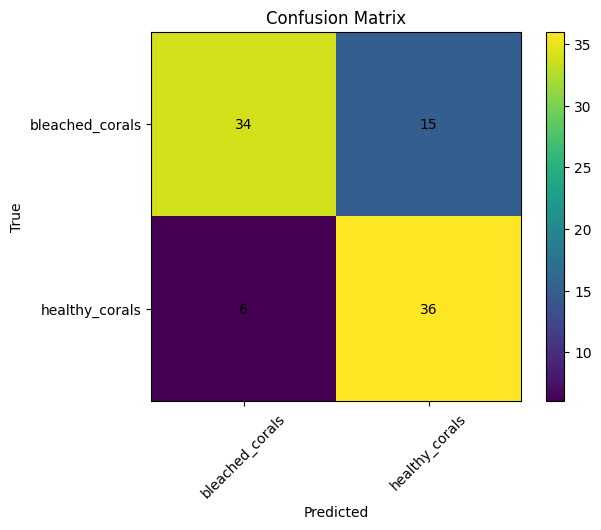

                 precision    recall  f1-score   support

bleached_corals     0.8500    0.6939    0.7640        49
 healthy_corals     0.7059    0.8571    0.7742        42

       accuracy                         0.7692        91
      macro avg     0.7779    0.7755    0.7691        91
   weighted avg     0.7835    0.7692    0.7687        91

F1 (macro): 0.7691192461036607


In [18]:
import numpy as np, itertools, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, f1_score
#We get the predictions we just made with this
y_true = [] #real labels
y_prob = [] # what our model found
for images, labels in test_ds:
    probs =model.predict(images).ravel() #
    y_prob.extend(probs)
    y_true.extend(labels.numpy().astype(int))
y_true = np.array(y_true)
y_prob = np.array(y_prob)
y_pred = (y_prob >= 0.5).astype(int) #Transforms the probabilty into a flat bleach/healthy

cm = confusion_matrix(y_true, y_pred)

def plot_cm(cm, classes): # To print the confusion matrix AND the numbers
    plt.imshow(cm, interpolation='nearest')
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xticks(range(len(classes)), classes, rotation=45)
    plt.yticks(range(len(classes)), classes)
    for i in range(cm.shape[0]): #Adding numbers for the cm
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha='center', va='center')

    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()
plot_cm(cm, class_names)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
print("F1 (macro):", f1_score(y_true, y_pred, average="macro"))
